# Installations

In [1]:
!pip install geopandas

# Temperature Heat Map

In [2]:
import pandas as pd

df = pd.read_csv("cleaned_GlobalLandTemperaturesByCountry.csv")
df.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'Month', 'Day', 'Weekday', 'Year'],
      dtype='object')

C:\Users\Abdul Rehman\AppData\Local\Temp\ipykernel_11764\2970291911.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


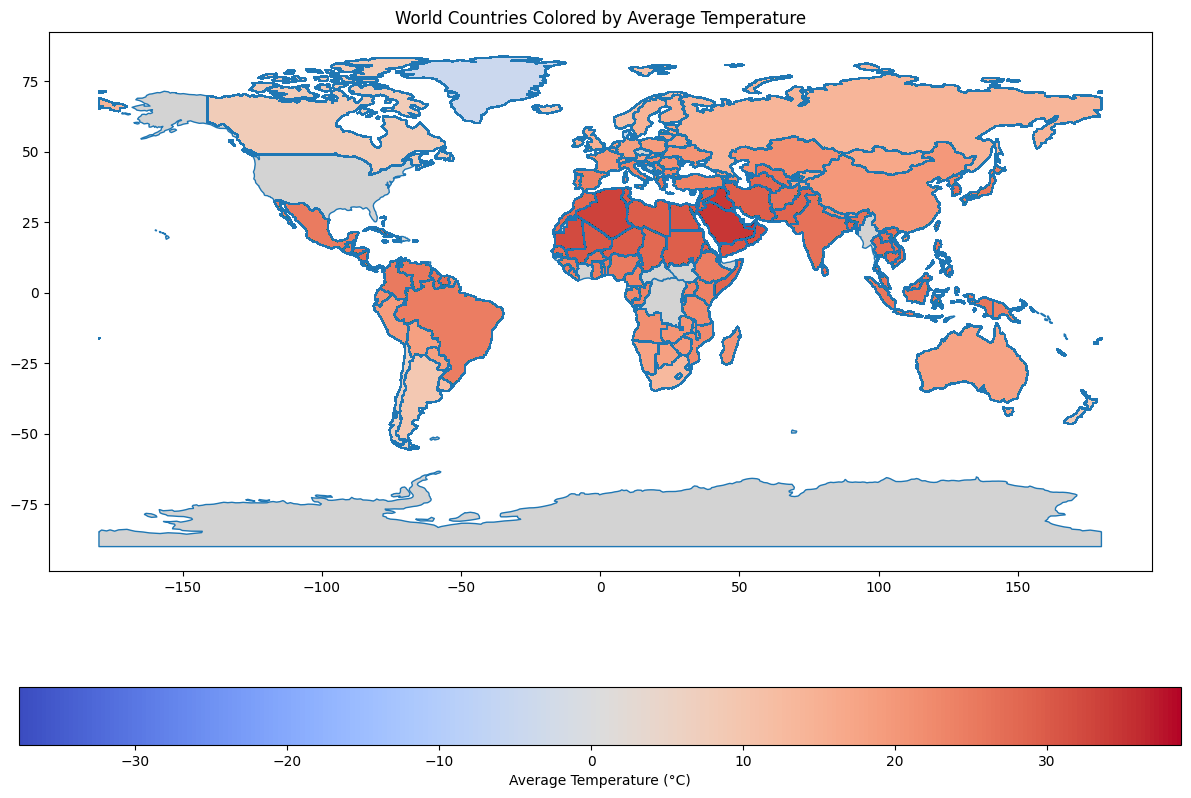

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(df, how="left", left_on="name", right_on="Country")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='AverageTemperature', ax=ax, legend=True,
           legend_kwds={'label': "Average Temperature (°C)", 'orientation': "horizontal"},
           cmap='coolwarm', missing_kwds={'color': 'lightgrey'})

plt.title('World Countries Colored by Average Temperature')
plt.show()

# Agricultural Production Heat Map

# Relationship between temperatures of a country and the crop yeilds

In [4]:
import pandas as pd

df1 = pd.read_csv("Cleaned_GlobalLandTemperaturesByCountry.csv")
df2 = pd.read_csv("yield_df.csv")
print(df1.columns)
print(df2.columns)

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'Month', 'Day', 'Weekday', 'Year'],
      dtype='object')
Index(['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp'],
      dtype='object')


In [5]:
# Merge datasets
df_merged = pd.merge(df1, df2, left_on=['Country', 'Year'], right_on=['Area', 'Year'])

# Select relevant columns (assuming we keep 'AverageTemperature' for consistency)
df_analysis = df_merged[['Country', 'Year', 'Item', 'hg/ha_yield', 'AverageTemperature']]

# Display the merged dataset ready for analysis
df_analysis

,Country,Year,Item,hg/ha_yield,AverageTemperature
0,Albania,1990,Maize,36613,2.310
1,Albania,1990,Potatoes,66667,2.310
2,Albania,1990,"Rice, paddy",23333,2.310
3,Albania,1990,Sorghum,12500,2.310
4,Albania,1990,Soybeans,7000,2.310
...,...,...,...,...,...
334020,Zimbabwe,2013,"Rice, paddy",22581,19.759
334021,Zimbabwe,2013,Sorghum,3066,19.759
334022,Zimbabwe,2013,Soybeans,13142,19.759
334023,Zimbabwe,2013,Sweet potatoes,22222,19.759


In [6]:
# Average temperature per country per year
avg_temp_per_year = df1.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Rename columns for a clear merge
avg_temp_per_year.rename(columns={'Country': 'Area', 'AverageTemperature': 'annual_avg_temp'}, inplace=True)

# Merge with agricultural data
df = pd.merge(df2, avg_temp_per_year, how='left', on=['Area', 'Year'])
df.columns

Index(['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'annual_avg_temp'],
      dtype='object')

# Time Series

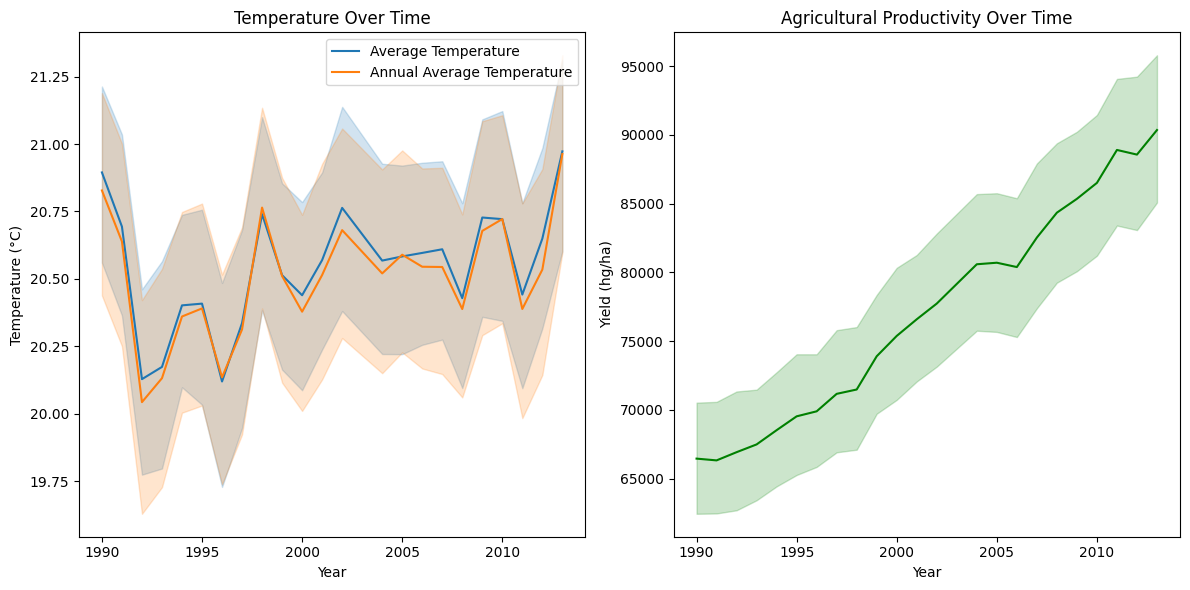

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Temperature over time
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x='Year', y='avg_temp', label='Average Temperature')
sns.lineplot(data=df, x='Year', y='annual_avg_temp', label='Annual Average Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()

# Yield over time
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x='Year', y='hg/ha_yield', color='green')
plt.title('Agricultural Productivity Over Time')
plt.xlabel('Year')
plt.ylabel('Yield (hg/ha)')

plt.tight_layout()
plt.show()


# Relationship between temperatures and agricultural yeild

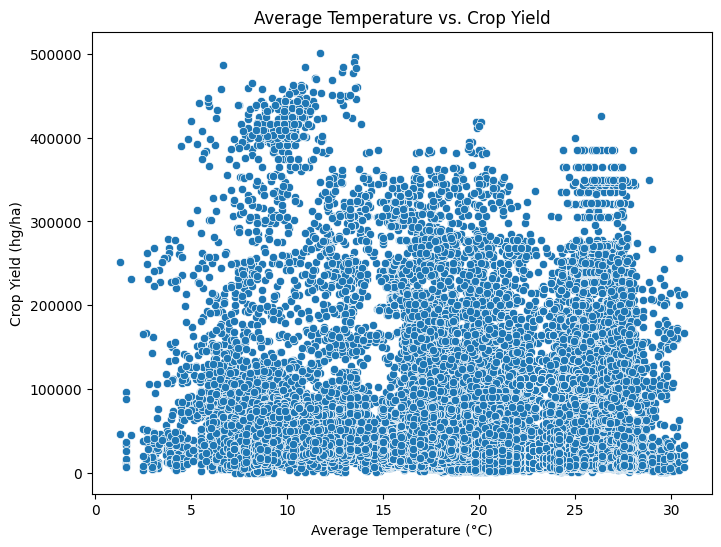

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='avg_temp', y='hg/ha_yield')
plt.title('Average Temperature vs. Crop Yield')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Crop Yield (hg/ha)')
plt.show()

# Map

In [10]:
import pycountry
import pandas as pd

# Convert country names to ISO Alpha-3 codes
def get_iso_alpha_3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None  # for countries that pycountry can't find

# Assuming `df` is your original DataFrame
df['iso_alpha'] = df['Area'].apply(get_iso_alpha_3)

# Check if there are any null values in 'iso_alpha' to ensure all countries were matched
print(df[df['iso_alpha'].isnull()]['Area'].unique())

country_agg = df.groupby('iso_alpha').agg({
    'avg_temp': 'mean',
    'hg/ha_yield': 'mean'
}).reset_index()

['Turkey']


In [11]:
import plotly.express as px

fig = px.choropleth(country_agg,
                    locations="iso_alpha",
                    color="avg_temp",
                    hover_name="iso_alpha",
                    hover_data={"avg_temp": ":.2f", "hg/ha_yield": ":.2f"},
                    color_continuous_scale=px.colors.sequential.OrRd,
                    labels={'avg_temp': 'Average Temperature (°C)', 'hg/ha_yield': 'Average Yield (hg/ha)'},
                    title='Global Temperatures and Their Impact on Agricultural Yield')

fig.update_layout(coloraxis_colorbar=dict(title="Temp (°C)"))
fig.show()

# Dashboard

In [12]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import pycountry

# Assuming 'Area' needs conversion to ISO Alpha-3
def get_iso_alpha_3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

df['iso_alpha'] = df['Area'].apply(get_iso_alpha_3)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='map', figure=px.choropleth(df, locations='iso_alpha', color='avg_temp', hover_name='Area')),
    dcc.Graph(id='yield_comparison')
])

@app.callback(
    Output('yield_comparison', 'figure'),
    [Input('map', 'clickData')]
)
def update_yield_comparison(clickData):
    if clickData is None:
        # Before any country is clicked, show an empty graph
        return go.Figure()
    
    # Extract the clicked country's ISO code
    country_iso = clickData['points'][0]['location']
    selected_country = df[df['iso_alpha'] == country_iso]['Area'].iloc[0]

    # Filter data for the selected country and calculate its average yield
    selected_country_data = df[df['Area'] == selected_country]
    selected_avg_yield = selected_country_data['hg/ha_yield'].mean()
    
    # Calculate global average yield for comparison
    global_avg_yield = df['hg/ha_yield'].mean()

    # Create comparison bar chart
    fig = go.Figure(data=[
        go.Bar(name=selected_country, x=[selected_country], y=[selected_avg_yield], marker_color='blue'),
        go.Bar(name='Global Average', x=['Global Average'], y=[global_avg_yield], marker_color='red')
    ])
    
    fig.update_layout(title=f'Yield Comparison: {selected_country} vs Global Average',
                      yaxis_title='Yield (hg/ha)')

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

C:\Users\Abdul Rehman\AppData\Local\Temp\ipykernel_11764\3986581718.py:2: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\Abdul Rehman\AppData\Local\Temp\ipykernel_11764\3986581718.py:3: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Function to create sequences for LSTM
def create_sequences(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Read the cleaned dataset
cleaned_df = pd.read_csv('Cleaned_GlobalLandTemperaturesByCountry.csv')

# Create a datetime column using 'Year', 'Month', and 'Day'
cleaned_df['dt'] = pd.to_datetime(cleaned_df[['Year', 'Month', 'Day']])

# Drop the original 'Year', 'Month', and 'Day' columns
cleaned_df = cleaned_df.drop(['Year', 'Month', 'Day'], axis=1)

# Sort the dataframe by date
cleaned_df = cleaned_df.sort_values(by='dt')

# Set 'dt' column as index
cleaned_df.set_index('dt', inplace=True)

# List of selected countries
selected_countries = ['Sweden', 'Germany', 'Italy', 'United Kingdom', 'France', 'Japan']

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Loop through each country
for country in selected_countries:
    country_df = cleaned_df[cleaned_df['Country'] == country]
    temperature_data = country_df['AverageTemperature'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    temperature_data_scaled = scaler.fit_transform(temperature_data)
    look_back = 12
    X, y = create_sequences(temperature_data_scaled, look_back)
    X = X.reshape(X.shape[0], look_back, 1)  # Reshape input for LSTM

    # LSTM model setup
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    future_days = 365
    lst_output = []
    n_steps = len(X)

    for i in range(future_days):
        if i < n_steps:
            lst_output.append(temperature_data_scaled[-n_steps + i, 0])
        else:
            x_input = np.array(lst_output[-look_back:]).reshape((1, look_back, 1))
            yhat = model.predict(x_input, verbose=0)
            lst_output.append(yhat[0, 0])

    future_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

    # Updating the world map with actual and predicted temperatures
    world.loc[world['name'] == country, 'ActualTemp'] = country_df['AverageTemperature'].iloc[-1]
    world.loc[world['name'] == country, 'PredictedTemp'] = future_predictions[-1][0]

# Plotting the actual temperature heatmap on the world map
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
world.dropna(subset=['ActualTemp']).plot(column='ActualTemp', ax=ax[0], legend=True, cmap='coolwarm')
ax[0].set_title('Actual Temperature Heatmap')

# Plotting the predicted temperature heatmap on the world map
world.dropna(subset=['PredictedTemp']).plot(column='PredictedTemp', ax=ax[1], legend=True, cmap='coolwarm')
ax[1].set_title('Predicted Temperature Heatmap')

plt.show()


C:\Users\Abdul Rehman\AppData\Local\Temp\ipykernel_6472\834935850.py:38: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Epoch 1/50
89/89 [==============================] - 10s 39ms/step - loss: 0.0777 - val_loss: 0.0423
Epoch 2/50
89/89 [==============================] - 2s 25ms/step - loss: 0.0147 - val_loss: 0.0056
Epoch 3/50
89/89 [==============================] - 2s 19ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/50
89/89 [==============================] - 2s 23ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 5/50
89/89 [==============================] - 2s 23ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 6/50
89/89 [==============================] - 2s 23ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 7/50
89/89 [==============================] - 2s 23ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 8/50
89/89 [==============================] - 3s 39ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 9/50
89/89 [==============================] - 5s 53ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/50
89/89 [==============================] - 3s 33ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 11

KeyboardInterrupt: 